# Standard MoE vs DeepSeek MoE: A Practical Comparison

So welcome to this notebook! In this notebook, we are gonna compare two different Mixture-of-Experts (MoE) architectures: the standard MoE approach used in many large language models versus the innovative DeepSeek-MoE architecture. We'll build both from scratch, train them on the same dataset, and see how they stack up against each other.

## What Are We Comparing?

**Standard MoE Architecture:**
- The "classic" approach used in models like Switch Transformers and GShard
- All experts are equal in size and function
- Uses an auxiliary loss to balance expert utilization
- Top-K routing sends each token to K experts

**DeepSeek MoE Architecture:**
- A newer approach with a hybrid expert system
- Combines "shared experts" (everyone uses them) with "routed experts" (only specific tokens use them)
- Uses a bias-only routing mechanism instead of auxiliary loss
- Aims for better quality and efficiency

## What Will We Learn?

By the end of this notebook, we'll understand:
1. How each architecture is implemented
2. Which one trains faster
3. Which one achieves better results
4. How experts are utilized in each approach

**Important Note:** The models we're building here are relatively small (only 6 layers with 512 embedding dimension) for demonstration purposes, so the differences won't be as dramatic as they would be at scale. In production-scale models with billions of parameters, these architectural differences would have much larger impacts on training efficiency and model quality.

In [12]:
!pip install datasets tiktoken tqdm numpy matplotlib pandas seaborn -q


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


## Setup and Environment Preparation

We'll start by installing the necessary dependencies for our experiment. This includes:
- `datasets`: To load and process the TinyStories dataset
- `tiktoken`: For tokenization using OpenAI's tokenizer (compatible with GPT-2)
- `tqdm`: For progress tracking during data processing and training
- `numpy`, `matplotlib`, `pandas`, `seaborn`: For data manipulation and visualization

These dependencies enable us to efficiently train our models and analyze the results in a systematic way.

In [13]:
# =============================================================================
# STAGE 1: SETUP, CONFIGURATION, AND DATA PREPARATION
# =============================================================================

# 1.1. Import Core Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import os
import time
from contextlib import nullcontext
from dataclasses import dataclass

# 1.2. Import Helper Libraries
import numpy as np
from datasets import load_dataset
import tiktoken
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd

print("All dependencies imported successfully.")

All dependencies imported successfully.


## Stage 1: Setup, Configuration, and Data Preparation

In this first stage, we'll:
1. Import necessary libraries for deep learning (PyTorch), data processing, and visualization
2. Configure the training parameters, including batch size, context length, learning rate, etc.
3. Define the DeepSeekMoEConfig class, which contains the architecture specifications for both models
4. Prepare and tokenize the TinyStories dataset

The DeepSeek MoE architecture has some key hyperparameters:
- `moe_n_routed_experts`: Number of specialized experts that process specific tokens (16 by default)
- `moe_top_k`: Number of experts selected per token (2 by default)
- `ds_moe_n_shared_experts`: Number of shared experts that process all tokens (2 by default)
- `ds_moe_shared_expert_hidden_dim`: Dimensionality of the shared experts (larger than routed experts)

For the standard MoE baseline, we'll adjust the number of experts to ensure both models have comparable parameter counts.

In [14]:
# 1.3. Global Training Configuration
BATCH_SIZE = 32
BLOCK_SIZE = 256
MAX_ITERS = 5000
EVAL_INTERVAL = 250
EVAL_ITERS = 100
LEARNING_RATE = 3e-4
WARMUP_ITERS = 200
MIN_LR = 3e-5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DTYPE = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
PTDTYPE = {'float16': torch.float16, 'bfloat16': torch.bfloat16, 'float32': torch.float32}[DTYPE]
CTX = nullcontext() if DEVICE == 'cpu' else torch.amp.autocast(device_type=DEVICE, dtype=PTDTYPE)
SCALER = torch.cuda.amp.GradScaler(enabled=(DTYPE == 'float16'))

/tmp/ipykernel_279/1440405301.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  SCALER = torch.cuda.amp.GradScaler(enabled=(DTYPE == 'float16'))


### Global Training Configuration

Here we define the key training parameters that will be used for both models:

- `BATCH_SIZE=32`: Number of sequences processed in parallel
- `BLOCK_SIZE=256`: Context length (number of tokens per sequence)
- `MAX_ITERS=5000`: Total number of training iterations
- `EVAL_INTERVAL=250`: How often to evaluate on the validation set
- `EVAL_ITERS=100`: Number of batches to use for evaluation
- `LEARNING_RATE=3e-4`: Initial learning rate
- `WARMUP_ITERS=200`: Number of iterations for learning rate warmup
- `MIN_LR=3e-5`: Minimum learning rate after decay

We also set up the device configuration (CUDA/CPU) and mixed precision training to optimize performance. Using `bfloat16` or `float16` significantly improves training speed on compatible GPUs while maintaining numerical stability.

In [15]:
@dataclass
class DeepSeekMoEConfig:
    # Core Transformer Params
    n_layer: int = 6
    n_head: int = 8
    n_embd: int = 512
    vocab_size: int = 50257
    block_size: int = BLOCK_SIZE
    dropout: float = 0.1
    bias: bool = False

    # MoE Specific Params for Fine-Grained Expert Segmentation
    moe_n_routed_experts: int = 16
    moe_top_k: int = 2
    moe_expert_hidden_dim: int = 512 # (n_embd * 4) / 4

    # Shared Expert Isolation
    ds_moe_n_shared_experts: int = 2
    ds_moe_shared_expert_hidden_dim: int = 1024 # Larger for generalist role

MODEL_CONFIG = DeepSeekMoEConfig()

print("\n--- Notebook Configuration ---")
print(f"Device: {DEVICE} with dtype: {DTYPE}")
print(f"Model: {MODEL_CONFIG.n_layer} layers, {MODEL_CONFIG.n_head} heads, {MODEL_CONFIG.n_embd} embedding dim.")
print(f"MoE: {MODEL_CONFIG.moe_n_routed_experts} routed experts (top {MODEL_CONFIG.moe_top_k}) + {MODEL_CONFIG.ds_moe_n_shared_experts} shared experts.")
print("-" * 30)


--- Notebook Configuration ---
Device: cuda with dtype: bfloat16
Model: 6 layers, 8 heads, 512 embedding dim.
MoE: 16 routed experts (top 2) + 2 shared experts.
------------------------------


### DeepSeek MoE Configuration

This is where we define the core architecture of our DeepSeek MoE model. The configuration includes:

**Core Transformer Parameters:**
- 6 layers with 8 attention heads each
- 512 embedding dimension (relatively small for demo purposes)
- Context length of 256 tokens

**MoE-Specific Parameters:**
- 16 routed experts (specialists) with top-2 routing
- Expert hidden dimension of 512 (reduced from the typical 4x expansion)

**Shared Expert Parameters:**
- 2 shared experts (generalists)
- Shared expert hidden dimension of 1024 (2x larger than routed experts)

This configuration represents the key innovation in DeepSeek's approach: having a small number of larger shared experts that process all tokens, combined with many smaller specialized experts that only process specific tokens through routing.

In [16]:
# 1.5. Dataset and Tokenizer Configuration
DATASET_NAME = "roneneldan/TinyStories"
TRAIN_BIN_FILE = "train.bin"
VAL_BIN_FILE = "val.bin"
TOKENIZER_MODEL = "gpt2"

### Dataset and Tokenization Setup

For our experiments, we'll use the **TinyStories** dataset, which contains simple stories suitable for language modeling tasks. We'll tokenize the data using the GPT-2 tokenizer from the `tiktoken` library.

The process involves:
1. Loading the dataset using the Hugging Face `datasets` library
2. Tokenizing each example with the GPT-2 tokenizer 
3. Adding an end-of-text token to each story
4. Writing the tokenized data to memory-mapped binary files for efficient loading during training

This approach allows us to process the data once and then efficiently load random batches during training, which is crucial for training language models effectively.

In [17]:
# 1.6. Tokenization and File Writing
if not (os.path.exists(TRAIN_BIN_FILE) and os.path.exists(VAL_BIN_FILE)):
    print("\nBinary data files not found. Starting data download and tokenization...")
    ds = load_dataset(DATASET_NAME)
    enc = tiktoken.get_encoding(TOKENIZER_MODEL)

    def process_and_tokenize(example):
        ids = enc.encode_ordinary(example['text'])
        # Add EOS token to signify document end
        ids.append(enc.eot_token)
        return {'ids': ids, 'len': len(ids)}

    tokenized_ds = ds.map(
        process_and_tokenize,
        remove_columns=['text'],
        desc="Tokenizing splits",
        num_proc=os.cpu_count(),
    )

    for split, dset in tokenized_ds.items():
        split_name = 'val' if split == 'validation' else split
        filename = f"{split_name}.bin"
        arr = np.memmap(filename, dtype=np.uint16, mode='w+', shape=(sum(dset['len']),))
        total_tokens = len(arr)
        print(f"Writing {total_tokens:,} tokens to {filename}...")
        
        idx = 0
        for example in tqdm(dset, desc=f"Writing {split_name} data"):
            arr[idx : idx + example['len']] = example['ids']
            idx += example['len']
        arr.flush()
    print("\nTokenization and file writing complete.")
else:
    print("\nFound existing train.bin and val.bin files. Skipping data preparation.")


Found existing train.bin and val.bin files. Skipping data preparation.


In [18]:
# 1.7. Data Loading Function
def get_batch(split):
    filename = TRAIN_BIN_FILE if split == 'train' else VAL_BIN_FILE
    data = np.memmap(filename, dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - BLOCK_SIZE, (BATCH_SIZE,))
    x = torch.stack([torch.from_numpy((data[i:i+BLOCK_SIZE]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+BLOCK_SIZE]).astype(np.int64)) for i in ix])
    return x.to(DEVICE), y.to(DEVICE)

print("\nStage 1 Complete: Setup and data utilities are ready.")
print("=" * 60)


Stage 1 Complete: Setup and data utilities are ready.


In [19]:
# =============================================================================
# STAGE 2: CONSTRUCTING THE CORE ARCHITECTURAL LAYERS
# =============================================================================

# -----------------------------------------------------------------------------
# 2.1. Multi-Head Attention
# -----------------------------------------------------------------------------

class MultiHeadAttention(nn.Module):
    """
    Implements the Multi-Head Self-Attention mechanism as described in the
    "Attention is All You Need" paper.
    """
    def __init__(self, config: DeepSeekMoEConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0, "Embedding dimension must be divisible by number of heads"

        # Key, Query, Value projections for all heads, but in a single batch operation
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # Regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        
        # Flash Attention-based scaled dot product attention is only available for PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: Using manual attention implementation. For faster training, upgrade PyTorch to 2.0 or higher.")
            # Causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.size() # Batch size, sequence length, embedding dimensionality (n_embd)

        # Calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        
        # Reshape for multi-head attention: (B, T, C) -> (B, n_head, T, head_size)
        head_size = C // self.n_head
        k = k.view(B, T, self.n_head, head_size).transpose(1, 2)
        q = q.view(B, T, self.n_head, head_size).transpose(1, 2)
        v = v.view(B, T, self.n_head, head_size).transpose(1, 2)

        # Causal self-attention; either with Flash Attention or manual implementation
        if self.flash:
            # Efficient attention using Flash Attention kernel
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # Manual implementation of attention
            # (B, n_head, T, head_size) @ (B, n_head, head_size, T) -> (B, n_head, T, T)
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            # (B, n_head, T, T) @ (B, n_head, T, head_size) -> (B, n_head, T, head_size)
            y = att @ v

        # Re-assemble all head outputs side by side: (B, n_head, T, head_size) -> (B, T, C)
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # Output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

# --- Verification Step ---
print("--- Verifying MultiHeadAttention Module ---")
# Create a dummy input tensor
dummy_config = DeepSeekMoEConfig()
dummy_input = torch.randint(0, dummy_config.vocab_size, (BATCH_SIZE, BLOCK_SIZE), device=DEVICE)
embedding_layer = nn.Embedding(dummy_config.vocab_size, dummy_config.n_embd, device=DEVICE)
dummy_x = embedding_layer(dummy_input)

# Instantiate and run the attention module
mha = MultiHeadAttention(dummy_config).to(DEVICE)
output = mha(dummy_x)

print(f"Input shape:  {dummy_x.shape}")
print(f"Output shape: {output.shape}")
assert dummy_x.shape == output.shape, "Output shape does not match input shape!"
print("MultiHeadAttention module implemented and verified successfully.")
print("=" * 60)

--- Verifying MultiHeadAttention Module ---
Input shape:  torch.Size([32, 256, 512])
Output shape: torch.Size([32, 256, 512])
MultiHeadAttention module implemented and verified successfully.


## Stage 2: Constructing Core Architectural Components

In this stage, we build the foundational components that both our Standard MoE and DeepSeek MoE models will use. The transformer architecture consists of:

1. **Multi-Head Attention**: Allows the model to attend to different positions in the input sequence
2. **Layer Normalization**: Stabilizes the activations between layers
3. **Feed-Forward Networks**: Processes token representations through MoE layers

### Multi-Head Attention Implementation

The Multi-Head Attention (MHA) mechanism is implemented following the standard approach from the "Attention is All You Need" paper:

1. Project input into query (Q), key (K), and value (V) representations
2. Split these projections across multiple attention heads
3. Compute scaled dot-product attention for each head
4. Concatenate outputs and project back to the original dimension

Our implementation includes optimizations like Flash Attention when available in PyTorch ≥ 2.0, which significantly improves performance for longer sequences.

In [20]:
# =============================================================================
# STAGE 2B: DEFINING THE STANDARD MOE BASELINE MODEL (CORRECTED)
# =============================================================================

# We re-use the same simple MLP Expert as before.
class Expert(nn.Module):
    def __init__(self, n_embd: int, hidden_dim: int, dropout: float = 0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, hidden_dim, bias=False),
            nn.GELU(),
            nn.Linear(hidden_dim, n_embd, bias=False),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)

# -----------------------------------------------------------------------------
# 2B.1. Standard MoE Layer with CORRECTED Auxiliary Loss
# -----------------------------------------------------------------------------
class StandardMoELayer(nn.Module):
    def __init__(self, config: DeepSeekMoEConfig):
        super().__init__()
        self.n_routed_experts = config.moe_n_routed_experts
        self.top_k = config.moe_top_k
        self.experts = nn.ModuleList([Expert(config.n_embd, config.moe_expert_hidden_dim, dropout=config.dropout) for _ in range(self.n_routed_experts)])
        self.router = nn.Linear(config.n_embd, self.n_routed_experts, bias=False)
        self.aux_loss_coef = 1e-2

    def forward(self, x: torch.Tensor):
        B, T, C = x.shape
        x_flat = x.view(-1, C)
        num_tokens = x_flat.shape[0]
        
        router_logits = self.router(x_flat)
        routing_weights = F.softmax(router_logits, dim=1, dtype=torch.float)
        topk_weights, topk_indices = torch.topk(routing_weights, self.top_k, dim=-1)
        gates = topk_weights / topk_weights.sum(dim=-1, keepdim=True)
        
        # --- CORRECTED Auxiliary Load Balancing Loss (as per the book) ---
        # f_i: fraction of tokens dispatched to expert i
        # p_i: fraction of router probability allocated to expert i
        
        # Calculate f_i for each expert
        expert_counts = torch.zeros(self.n_routed_experts, device=x.device)
        expert_counts.index_add_(0, topk_indices.view(-1), torch.ones_like(topk_indices.view(-1), dtype=torch.float))
        f_i = expert_counts / num_tokens
        
        # Calculate p_i for each expert
        p_i = routing_weights.mean(dim=0)
        
        # The loss is the dot product of these two distributions, scaled
        aux_loss = self.n_routed_experts * torch.sum(p_i * f_i) * self.aux_loss_coef

        # Dispatch tokens
        final_output_flat = torch.zeros_like(x_flat)
        for i in range(self.n_routed_experts):
            mask = (topk_indices == i)
            row_idx, which_k = mask.nonzero(as_tuple=True)
            if row_idx.numel() == 0: continue
            
            expert_in = x_flat.index_select(0, row_idx)
            expert_out = self.experts[i](expert_in)
            gate_values = gates[row_idx, which_k].unsqueeze(1)
            
            final_output_flat.index_add_(0, row_idx, expert_out * gate_values)
            
        return final_output_flat.view(B, T, C), aux_loss

# --- The Block and Full GPT Model definitions remain the same as before ---

class StandardMoEBlock(nn.Module):
    def __init__(self, config: DeepSeekMoEConfig):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd, bias=config.bias)
        self.attn = MultiHeadAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd, bias=config.bias)
        self.moe = StandardMoELayer(config)

    def forward(self, x: torch.Tensor):
        x = x + self.attn(self.ln_1(x))
        moe_out, aux_loss = self.moe(self.ln_2(x))
        x = x + moe_out
        return x, aux_loss

class StandardMoEGPT(nn.Module):
    def __init__(self, config: DeepSeekMoEConfig):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([StandardMoEBlock(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.size()
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        
        total_aux_loss = 0.0
        for block in self.transformer.h:
            x, aux_loss = block(x)
            total_aux_loss += aux_loss

        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            main_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            total_loss = main_loss + total_aux_loss / self.config.n_layer
        else:
            logits = self.lm_head(x[:, [-1], :])
            total_loss = None
        
        return logits, total_loss

    def get_num_params(self, non_embedding=True):
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

# --- Verification Step ---
print("--- Verifying Standard MoE Baseline Model Architecture (Corrected) ---")
# Create a dedicated config for the Standard MoE model to adjust its parameters
std_moe_config = DeepSeekMoEConfig()
# To make parameters roughly equal to DeepSeekMoE (101.28M vs 82.41M), we add 6 experts
# to compensate for the 2 large shared experts in the DeepSeek model.
# 16 (original) + 6 (compensation) = 22
std_moe_config.moe_n_routed_experts = 22

std_moe_dummy_model = StandardMoEGPT(std_moe_config).to(DEVICE)
dummy_input = torch.randint(0, std_moe_config.vocab_size, (BATCH_SIZE, BLOCK_SIZE), device=DEVICE)
logits, loss = std_moe_dummy_model(dummy_input, dummy_input)
print(f"Dummy forward pass successful. Logits shape: {logits.shape}, Loss: {loss.item():.4f}")
print(f"Total model parameters: {std_moe_dummy_model.get_num_params()/1e6:.2f}M")
del std_moe_dummy_model, dummy_input, logits, loss, std_moe_config
print("Standard MoE architecture defined and verified successfully.")
print("=" * 60)

--- Verifying Standard MoE Baseline Model Architecture (Corrected) ---
Dummy forward pass successful. Logits shape: torch.Size([32, 256, 50257]), Loss: 10.0135
Total model parameters: 101.30M
Standard MoE architecture defined and verified successfully.


## Stage 2B: Standard MoE Architecture Implementation

Here we implement the baseline Standard MoE architecture for comparison. Key components include:

### Expert Module

A simple MLP (Multi-Layer Perceptron) with:
- Linear projection to a hidden dimension
- GELU activation
- Linear projection back to the embedding dimension
- Dropout for regularization

### Standard MoE Layer

The Standard MoE approach follows the design pattern established by GShard and Switch Transformers:

1. **Router**: A linear layer that outputs routing probabilities for each expert
2. **Top-K Selection**: Each token is routed to the k highest-probability experts
3. **Expert Processing**: Selected experts process the tokens
4. **Weighted Combination**: Expert outputs are combined according to router probabilities
5. **Auxiliary Load Balancing Loss**: Encourages uniform expert utilization

For a fair comparison with DeepSeek MoE, we configure the Standard MoE with 22 experts (vs. DeepSeek's 16 routed + 2 shared) to achieve similar parameter counts between the models.

In [22]:
# =============================================================================
# STAGE 3B: TRAINING THE STANDARD MOE BASELINE MODEL (CORRECTED)
# =============================================================================

print("\n--- Phase 2: Training the Standard MoE Model ---")

# --- Model Initialization ---
# FIX: Use the modified config to train the larger model as verified in the previous step
std_moe_config = DeepSeekMoEConfig()
std_moe_config.moe_n_routed_experts = 22

standard_moe_model = StandardMoEGPT(std_moe_config)
standard_moe_model.to(DEVICE)
print(f"Standard MoE Model initialized on {DEVICE}.")
print(f"Total model parameters: {standard_moe_model.get_num_params()/1e6:.2f}M")

# --- Optimizer ---
optimizer = torch.optim.AdamW(standard_moe_model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.95), weight_decay=0.1)

# --- FIX: Learning Rate Scheduler function was missing ---
def get_lr(it):
    if it < WARMUP_ITERS: return LEARNING_RATE * it / WARMUP_ITERS
    if it > MAX_ITERS: return MIN_LR
    decay_ratio = (it - WARMUP_ITERS) / (MAX_ITERS - WARMUP_ITERS)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return MIN_LR + coeff * (LEARNING_RATE - MIN_LR)

# --- Loss Estimation ---
@torch.no_grad()
def estimate_loss_std_moe():
    out = {}
    standard_moe_model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(EVAL_ITERS)
        for k in range(EVAL_ITERS):
            X, Y = get_batch(split)
            with CTX:
                logits, loss = standard_moe_model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    standard_moe_model.train()
    return out

# --- Training Loop ---
print("\nStarting Standard MoE model training...")
# FIX: Initialize the results dictionary since the FFN cell was removed
comparison_results = {}
train_losses, val_losses = [], []
start_time = time.time()

for iter_num in range(MAX_ITERS + 1):
    lr = get_lr(iter_num)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    if iter_num % EVAL_INTERVAL == 0:
        losses = estimate_loss_std_moe()
        val_loss = losses['val']
        val_losses.append(val_loss)
        train_losses.append(losses['train'])
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {val_loss:.4f}, lr {lr:.6f}")

    X, Y = get_batch('train')

    # Forward pass
    with CTX:
        logits, loss = standard_moe_model(X, Y)

    # Backward pass and optimizer step
    SCALER.scale(loss).backward()
    SCALER.step(optimizer)
    SCALER.update()
    optimizer.zero_grad(set_to_none=True)

end_time = time.time()
std_moe_train_time = (end_time - start_time) / 60
print(f"\nStandard MoE Training finished in {std_moe_train_time:.2f} minutes.")

# --- Store results for comparison ---
comparison_results['standard_moe'] = {
    'model': standard_moe_model.cpu(),
    'val_losses': val_losses,
    'train_time_minutes': std_moe_train_time
}
print("Phase 2 Complete: Standard MoE model trained and results stored.")
print("=" * 60)


--- Phase 2: Training the Standard MoE Model ---
Standard MoE Model initialized on cuda.
Total model parameters: 101.30M

Starting Standard MoE model training...
step 0: train loss 10.9298, val loss 10.9315, lr 0.000000
step 250: train loss 3.8924, val loss 3.8960, lr 0.000300
step 500: train loss 3.1836, val loss 3.1831, lr 0.000297
step 750: train loss 2.8639, val loss 2.8613, lr 0.000291
step 1000: train loss 2.6616, val loss 2.6783, lr 0.000282
step 1250: train loss 2.5478, val loss 2.5470, lr 0.000269
step 1500: train loss 2.4382, val loss 2.4323, lr 0.000254
step 1750: train loss 2.3573, val loss 2.3581, lr 0.000236
step 2000: train loss 2.2876, val loss 2.2754, lr 0.000217
step 2250: train loss 2.2467, val loss 2.2571, lr 0.000196
step 2500: train loss 2.1829, val loss 2.1934, lr 0.000174
step 2750: train loss 2.1636, val loss 2.1539, lr 0.000152
step 3000: train loss 2.1145, val loss 2.1109, lr 0.000130
step 3250: train loss 2.0946, val loss 2.0996, lr 0.000109
step 3500: trai

## Stage 3B: Training the Standard MoE Baseline Model

In this stage, we train the Standard MoE model using the configuration established earlier:

- 22 experts (to match parameter count with DeepSeek MoE)
- Top-2 routing
- Auxiliary load balancing loss

The training procedure includes:

1. **Model Initialization**: Create the Standard MoE model and move it to the appropriate device
2. **Optimizer Setup**: AdamW optimizer with weight decay for regularization
3. **Learning Rate Schedule**: Warmup followed by cosine decay
4. **Evaluation**: Periodic validation to track model performance
5. **Mixed Precision**: Using `float16` or `bfloat16` to accelerate training

The training loop includes forward passes, gradient scaling (for mixed precision), backward passes, and optimizer steps. We'll track metrics like training time, throughput, and validation loss for comparison with the DeepSeek MoE model.

In [23]:
# -----------------------------------------------------------------------------
# 2.2. Expert Modules
# -----------------------------------------------------------------------------

class Expert(nn.Module):
    """ A standard MLP expert for the routed experts. Uses GELU activation. """
    def __init__(self, n_embd: int, hidden_dim: int, dropout: float = 0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, hidden_dim, bias=False),
            nn.GELU(),
            nn.Linear(hidden_dim, n_embd, bias=False),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)

class SharedExpert(nn.Module):
    """ Shared experts. """
    def __init__(self, n_embd: int, hidden_dim: int, dropout: float = 0.0):
        super().__init__()
        self.w1 = nn.Linear(n_embd, hidden_dim, bias=False)
        self.w3 = nn.Linear(n_embd, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, n_embd, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.w2(self.dropout(F.silu(self.w1(x)) * self.w3(x)))

## Expert Modules for DeepSeek MoE

The DeepSeek MoE architecture uses two different types of expert modules:

### 1. Standard Expert Module

Used for the routed experts (specialists), this is a simple MLP with:
- Linear projection to a hidden dimension (typically smaller than in standard MoE)
- GELU activation function
- Linear projection back to the embedding dimension
- Dropout for regularization

### 2. Shared Expert Module (Key Innovation)

Used for the shared experts (generalists), this uses a SwiGLU activation:
- Two parallel linear projections from input to hidden dimension
- SiLU (Sigmoid Linear Unit) activation for one branch
- Multiply the two branches element-wise
- Linear projection back to the embedding dimension
- Dropout for regularization

This split architecture allows the shared experts to capture general patterns across all tokens, while the routed experts can specialize in specific linguistic features or patterns.

In [24]:
# =============================================================================
# STAGE 2 (REVISED): DeepSeekMoELayer with Key Innovation Fixes
# =============================================================================

class DeepSeekMoELayer(nn.Module):
    def __init__(self, config: DeepSeekMoEConfig):
        super().__init__()
        self.n_routed_experts = config.moe_n_routed_experts
        self.top_k = config.moe_top_k

        # Shared Experts (Generalists)
        self.shared_experts = nn.ModuleList([
            SharedExpert(config.n_embd, config.ds_moe_shared_expert_hidden_dim, dropout=config.dropout)
            for _ in range(config.ds_moe_n_shared_experts)
        ])

        # Routed Experts (Specialists)
        self.routed_experts = nn.ModuleList([
            Expert(config.n_embd, config.moe_expert_hidden_dim, dropout=config.dropout)
            for _ in range(self.n_routed_experts)
        ])

        # Router: A simple linear layer that outputs logits
        self.router = nn.Linear(config.n_embd, self.n_routed_experts, bias=False)

        # Non-trainable buffer for the auxiliary-loss-free bias term
        self.register_buffer("router_bias", torch.zeros(self.n_routed_experts))
        
        # Bias update parameters (as per reference)
        self.bias_update_gamma = 1e-3 # Corresponds to gamma_initial
        self.clamp_abs = 2.0 # Optional clamping for stability
        self.tol_frac = 0.0 # Tolerance fraction, 0.0 means we always update if not perfectly balanced

        # For interpretability
        self.router_indices = None

    def _affinity(self, x_flat: torch.Tensor) -> torch.Tensor:
        """
        FIX 1: Compute s = sigmoid(linear(x)) in fp32.
        The router logits are computed in the model's dtype (e.g., bfloat16) for performance,
        but the sigmoid and resulting affinity scores 's' are kept in float32 for numerical stability.
        """
        router_logits = self.router(x_flat)
        return torch.sigmoid(router_logits.float()) # Return fp32 affinity scores

    def forward(self, x: torch.Tensor, analysis_mode=False):
        B, T, C = x.shape
        x_flat = x.view(-1, C) # Shape: (B*T, C)

        # --- 1. Shared Expert Path (Dense) ---
        # FIX 3: Sum shared experts with unit weight.
        shared_out_flat = torch.zeros_like(x_flat)
        for expert in self.shared_experts:
            shared_out_flat += expert(x_flat)

        # --- 2. Routed Expert Path (Sparse) ---
        # 2a. Calculate affinity scores 's' and select Top-K using 's + b'
        s = self._affinity(x_flat) # [N, E] in fp32
        sel_scores = s + self.router_bias.to(s.device) # Add bias for selection
        topk_indices = torch.topk(sel_scores, self.top_k, dim=-1).indices # [N, K]

        # 2b. Calculate gates from the original, unbiased 's'
        # FIX 2: Gates = normalize(s.gather(TopK)). Bias is NEVER included in gates.
        s_sel = s.gather(dim=1, index=topk_indices) # [N, K]
        denom = s_sel.sum(dim=1, keepdim=True)
        # Fallback to 1/K if sum is tiny to prevent division by zero
        gates = torch.where(
            denom > 1e-9,
            s_sel / (denom + 1e-9),
            torch.full_like(s_sel, 1.0 / self.top_k)
        ).to(x.dtype) # [N, K]

        # For interpretability
        if analysis_mode:
            self.router_indices = topk_indices.detach().cpu()

        # 2c. Dispatch tokens and combine outputs
        # FIX 5: Correct, efficient dispatch logic.
        routed_out_flat = torch.zeros_like(x_flat)
        for i in range(self.n_routed_experts):
            # Create a mask for tokens routed to expert 'i'
            mask = (topk_indices == i)
            row_idx, which_k = mask.nonzero(as_tuple=True)

            if row_idx.numel() == 0:
                continue

            # Select the input tokens for this expert
            expert_in = x_flat.index_select(0, row_idx)
            # Run the expert
            expert_out = self.routed_experts[i](expert_in)
            # Select the gating weights for these specific tokens and expert
            gate_values = gates[row_idx, which_k].unsqueeze(1)
            # Weight the expert output by its gate
            weighted_expert_out = expert_out * gate_values
            # Add the result back to the final output tensor at the correct positions
            routed_out_flat.index_add_(0, row_idx, weighted_expert_out)

        # --- 3. Final Combination ---
        # FIX 3: Add residual 'x' in the final output.
        final_output = x + shared_out_flat.view(B, T, C) + routed_out_flat.view(B, T, C)
        return final_output

    @torch.no_grad()
    def update_bias(self):
        """
        FIX 4: Implements the stepwise ±gamma bias update.
        This is a simplified version of the reference, capturing the core logic.
        A full implementation would include gamma annealing.
        """
        # This method should be called with the same batch of data used in the forward pass
        # For simplicity in our training loop, we'll recalculate the counts here.
        # In a highly optimized framework, you might pass the counts from the forward pass.
        
        # We need a dummy forward pass to get the counts for the *current* bias state
        # This is a conceptual placeholder. In the actual training loop, we'll use the
        # counts from the last forward pass before the optimizer step.
        # For now, let's define the logic assuming we have the `counts`.
        # The actual call will be handled in the training loop.
        pass # The logic will be implemented directly in the training loop for clarity.

# --- Verification Step ---
print("--- Verifying REVISED DeepSeekMoELayer Module ---")
dummy_config = DeepSeekMoEConfig()
dummy_input = torch.randn(BATCH_SIZE, BLOCK_SIZE, dummy_config.n_embd, device=DEVICE)

moe_layer = DeepSeekMoELayer(dummy_config).to(DEVICE)
output = moe_layer(dummy_input)

print(f"Input shape:  {dummy_input.shape}")
print(f"Output shape: {output.shape}")
assert dummy_input.shape == output.shape, "Output shape does not match input shape!"
print("\nREVISED DeepSeekMoELayer module implemented and verified successfully.")
print("Stage 2 Complete: All core architectural layers are defined.")
print("=" * 60)

--- Verifying REVISED DeepSeekMoELayer Module ---
Input shape:  torch.Size([32, 256, 512])
Output shape: torch.Size([32, 256, 512])

REVISED DeepSeekMoELayer module implemented and verified successfully.
Stage 2 Complete: All core architectural layers are defined.


## DeepSeek MoE Layer Implementation

The DeepSeek MoE layer represents the key innovation in this architecture, combining shared experts with routed experts and using a bias-only routing mechanism. Here's how it works:

### 1. Shared Expert Path (Dense)
- All tokens are processed by all shared experts
- The outputs from shared experts are summed with unit weight
- No routing is involved in this path

### 2. Routed Expert Path (Sparse)
- **Affinity Scores**: Calculate sigmoid(router(x)) for each token and expert
- **Bias Addition**: Add a learned bias term to the affinity scores for expert selection
- **Top-K Selection**: Select the K experts with highest (score + bias) for each token
- **Gate Computation**: Calculate normalized gates from the original scores (without bias)
- **Token Processing**: Route tokens to selected experts and process them
- **Output Combination**: Combine expert outputs weighted by the gate values

### 3. Auxiliary-Loss-Free Bias Update
Instead of using an auxiliary loss for load balancing (which can compete with the main language modeling objective), DeepSeek MoE uses a bias update mechanism:
- After each training step, update the router bias terms
- Increase bias for underutilized experts and decrease for overutilized ones
- This encourages balanced expert utilization without affecting the main loss

This approach allows the router to focus entirely on routing tokens to the most relevant experts for the task, rather than being constrained by an auxiliary load balancing objective.

In [25]:
# =============================================================================
# STAGE 3: ASSEMBLING AND TRAINING THE FULL MODEL
# =============================================================================

# -----------------------------------------------------------------------------
# 3.1. The Transformer Block
# -----------------------------------------------------------------------------

class Block(nn.Module):
    """ A single Transformer block combining Multi-Head Attention and our DeepSeekMoE layer. """
    def __init__(self, config: DeepSeekMoEConfig):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd, bias=config.bias)
        self.attn = MultiHeadAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd, bias=config.bias)
        self.moe = DeepSeekMoELayer(config)

    # <--- MODIFIED: This function now returns the MoE input as well
    def forward(self, x: torch.Tensor, analysis_mode=False):
        x = x + self.attn(self.ln_1(x))
        # Capture the input to the MoE layer before it's processed
        moe_input = self.ln_2(x)
        # The MoE layer's output is the FFN part, which we add to the residual path
        x = x + self.moe(moe_input, analysis_mode=analysis_mode)
        # Return both the final output and the captured input for the bias update
        return x, moe_input

# -----------------------------------------------------------------------------
# 3.2. The Full GPT Model with DeepSeek-MoE
# -----------------------------------------------------------------------------

# NOTE: The re-definitions of SharedExpert and DeepSeekMoELayer are redundant
# if the previous cells were run, but we keep them here for completeness as in the original notebook.

class SharedExpert(nn.Module):
    """ A SwiGLU expert, used for the shared experts. """
    def __init__(self, n_embd: int, hidden_dim: int, dropout: float = 0.0):
        super().__init__()
        self.w1 = nn.Linear(n_embd, hidden_dim, bias=False)
        self.w3 = nn.Linear(n_embd, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, n_embd, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.w2(self.dropout(F.silu(self.w1(x)) * self.w3(x)))

class DeepSeekMoELayer(nn.Module):
    def __init__(self, config: DeepSeekMoEConfig):
        super().__init__()
        self.n_routed_experts = config.moe_n_routed_experts
        self.top_k = config.moe_top_k
        self.shared_experts = nn.ModuleList([
            SharedExpert(config.n_embd, config.ds_moe_shared_expert_hidden_dim, dropout=config.dropout)
            for _ in range(config.ds_moe_n_shared_experts)
        ])
        self.routed_experts = nn.ModuleList([
            Expert(config.n_embd, config.moe_expert_hidden_dim, dropout=config.dropout)
            for _ in range(self.n_routed_experts)
        ])
        self.router = nn.Linear(config.n_embd, self.n_routed_experts, bias=False)
        self.register_buffer("router_bias", torch.zeros(self.n_routed_experts))
        self.bias_update_gamma = 1e-3
        self.router_indices = None

    def _affinity(self, x_flat: torch.Tensor) -> torch.Tensor:
        router_logits = self.router(x_flat)
        return torch.sigmoid(router_logits.float())

    def forward(self, x: torch.Tensor, analysis_mode=False):
        B, T, C = x.shape
        x_flat = x.view(-1, C)
        
        shared_out_flat = torch.zeros_like(x_flat)
        for expert in self.shared_experts:
            shared_out_flat += expert(x_flat)

        s = self._affinity(x_flat)
        sel_scores = s + self.router_bias.to(s.device)
        topk_indices = torch.topk(sel_scores, self.top_k, dim=-1).indices
        
        if analysis_mode:
            self.router_indices = topk_indices.detach().cpu()

        s_sel = s.gather(dim=1, index=topk_indices)
        denom = s_sel.sum(dim=1, keepdim=True)
        gates = torch.where(denom > 1e-9, s_sel / (denom + 1e-9), torch.full_like(s_sel, 1.0 / self.top_k)).to(x.dtype)

        routed_out_flat = torch.zeros_like(x_flat)
        for i in range(self.n_routed_experts):
            mask = (topk_indices == i)
            row_idx, which_k = mask.nonzero(as_tuple=True)
            if row_idx.numel() == 0: continue
            expert_in = x_flat.index_select(0, row_idx)
            expert_out = self.routed_experts[i](expert_in)
            gate_values = gates[row_idx, which_k].unsqueeze(1)
            weighted_expert_out = expert_out * gate_values
            routed_out_flat.index_add_(0, row_idx, weighted_expert_out)

        # As per the logic in the Block, this layer only returns the FFN output
        return shared_out_flat.view(B, T, C) + routed_out_flat.view(B, T, C)


class DeepSeekMoEGPT(nn.Module):
    def __init__(self, config: DeepSeekMoEConfig):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            # This will now use the modified Block that returns two values
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    # <--- MODIFIED: This function now returns router_inputs for the bias update
    def forward(self, idx, targets=None, analysis_mode=False):
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        
        router_inputs = [] # <--- MODIFIED: Initialize list to store MoE inputs
        for block in self.transformer.h:
            # <--- MODIFIED: Unpack both the output and the MoE input
            x, moe_input = block(x, analysis_mode=analysis_mode)
            router_inputs.append(moe_input) # <--- MODIFIED: Store the input

        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None
        
        # <--- MODIFIED: Return the collected router inputs
        return logits, loss, router_inputs

    def get_num_params(self, non_embedding=True):
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

# -----------------------------------------------------------------------------
# 3.3. The Training Loop
# -----------------------------------------------------------------------------

# --- Model Initialization ---
deepseek_moe_model = DeepSeekMoEGPT(MODEL_CONFIG)
deepseek_moe_model.to(DEVICE)
print(f"\nDeepSeek-MoE Model initialized on {DEVICE}.")
print(f"Total model parameters: {deepseek_moe_model.get_num_params()/1e6:.2f}M")

# --- Optimizer ---
# FIX: The optimizer needs to be created with the correctly named model variable.
optimizer = torch.optim.AdamW(deepseek_moe_model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.95), weight_decay=0.1)

# --- Learning Rate Scheduler ---
def get_lr(it):
    if it < WARMUP_ITERS:
        return LEARNING_RATE * it / WARMUP_ITERS
    if it > MAX_ITERS:
        return MIN_LR
    decay_ratio = (it - WARMUP_ITERS) / (MAX_ITERS - WARMUP_ITERS)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return MIN_LR + coeff * (LEARNING_RATE - MIN_LR)

# --- Loss Estimation ---
@torch.no_grad()
def estimate_loss_deepseek():
    out = {}
    # FIX: Use the correct model variable name here.
    deepseek_moe_model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(EVAL_ITERS)
        for k in range(EVAL_ITERS):
            X, Y = get_batch(split)
            with CTX:
                # FIX: And here.
                logits, loss, _ = deepseek_moe_model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    # FIX: And here.
    deepseek_moe_model.train()
    return out

# --- Training Loop ---
print("\nStarting DeepSeek-MoE model training...")
train_losses, val_losses = [], []
start_time = time.time()

for iter_num in range(MAX_ITERS + 1):
    lr = get_lr(iter_num)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    if iter_num % EVAL_INTERVAL == 0:
        # FIX: Call the correctly named estimation function
        losses = estimate_loss_deepseek()
        val_loss = losses['val']
        val_losses.append(val_loss)
        train_losses.append(losses['train'])
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {val_loss:.4f}, lr {lr:.6f}")

    X, Y = get_batch('train')

    # Forward pass
    with CTX:
        # FIX: Use the correct model variable name here.
        logits, loss, router_inputs = deepseek_moe_model(X, Y)

    # Backward pass and optimizer step
    SCALER.scale(loss).backward()
    SCALER.step(optimizer)
    SCALER.update()
    optimizer.zero_grad(set_to_none=True)

    # --- Auxiliary-Loss-Free Bias Update ---
    with torch.no_grad():
        # FIX: And here.
        for i, block in enumerate(deepseek_moe_model.transformer.h):
            moe_layer = block.moe
            x_flat = router_inputs[i].view(-1, MODEL_CONFIG.n_embd)
            # Recalculate router scores with current bias for selection
            s = moe_layer._affinity(x_flat)
            sel_scores = s + moe_layer.router_bias.to(s.device)
            topk_indices = torch.topk(sel_scores, moe_layer.top_k, dim=-1).indices
            
            counts = torch.bincount(topk_indices.view(-1), minlength=moe_layer.n_routed_experts).float()
            
            avg_load = counts.sum() / moe_layer.n_routed_experts
            load_violation = (counts - avg_load) / (avg_load + 1e-6)
            moe_layer.router_bias -= moe_layer.bias_update_gamma * load_violation

end_time = time.time()
deepseek_train_time = (end_time - start_time)/60
print(f"\nDeepSeek-MoE Training finished in {deepseek_train_time:.2f} minutes.")

# --- Store results for comparison ---
# This part is now correct because the variable 'deepseek_moe_model' has been used throughout.
comparison_results['deepseek_moe'] = {
    'model': deepseek_moe_model.cpu(),
    'val_losses': val_losses,
    'train_time_minutes': deepseek_train_time
}
print("Phase 3 Complete: DeepSeek-MoE model trained and results stored.")
print("=" * 60)

# Clean up GPU memory
import gc
del deepseek_moe_model, optimizer, router_inputs, loss, logits, X, Y
gc.collect()
torch.cuda.empty_cache()


DeepSeek-MoE Model initialized on cuda.
Total model parameters: 101.28M

Starting DeepSeek-MoE model training...
step 0: train loss 10.9208, val loss 10.9202, lr 0.000000
step 250: train loss 3.8481, val loss 3.8488, lr 0.000300
step 500: train loss 3.1489, val loss 3.1669, lr 0.000297
step 750: train loss 2.8288, val loss 2.8259, lr 0.000291
step 1000: train loss 2.6331, val loss 2.6485, lr 0.000282
step 1250: train loss 2.5059, val loss 2.5211, lr 0.000269
step 1500: train loss 2.3838, val loss 2.3887, lr 0.000254
step 1750: train loss 2.3141, val loss 2.3225, lr 0.000236
step 2000: train loss 2.2629, val loss 2.2603, lr 0.000217
step 2250: train loss 2.1967, val loss 2.2090, lr 0.000196
step 2500: train loss 2.1476, val loss 2.1519, lr 0.000174
step 2750: train loss 2.1064, val loss 2.1042, lr 0.000152
step 3000: train loss 2.0692, val loss 2.0880, lr 0.000130
step 3250: train loss 2.0395, val loss 2.0404, lr 0.000109
step 3500: train loss 2.0177, val loss 2.0145, lr 0.000090
step 

## Stage 3: Assembling and Training the Full DeepSeek MoE Model

Now we assemble the complete DeepSeek MoE model and train it using the same dataset and training procedures as the Standard MoE model for fair comparison.

### Model Architecture

The full model consists of:
1. **Token and Position Embeddings**: To convert token IDs to embeddings and encode position information
2. **Transformer Blocks**: Each with:
   - Layer Normalization
   - Multi-Head Attention
   - Layer Normalization
   - DeepSeek MoE Layer (with shared and routed experts)
3. **Final Layer Normalization and Language Modeling Head**

### Training Process

The training process mirrors that of the Standard MoE model:
- Same optimizer (AdamW)
- Same learning rate schedule (warmup + cosine decay)
- Same evaluation intervals
- Same mixed precision settings

**Key Difference**: Instead of computing an auxiliary load balancing loss, we update the router bias terms after each optimization step to encourage balanced expert utilization without affecting the main language modeling objective.

We'll track the same metrics (training time, throughput, validation loss) to enable a fair comparison between the two approaches.


--- Plotting Validation Loss Comparison ---


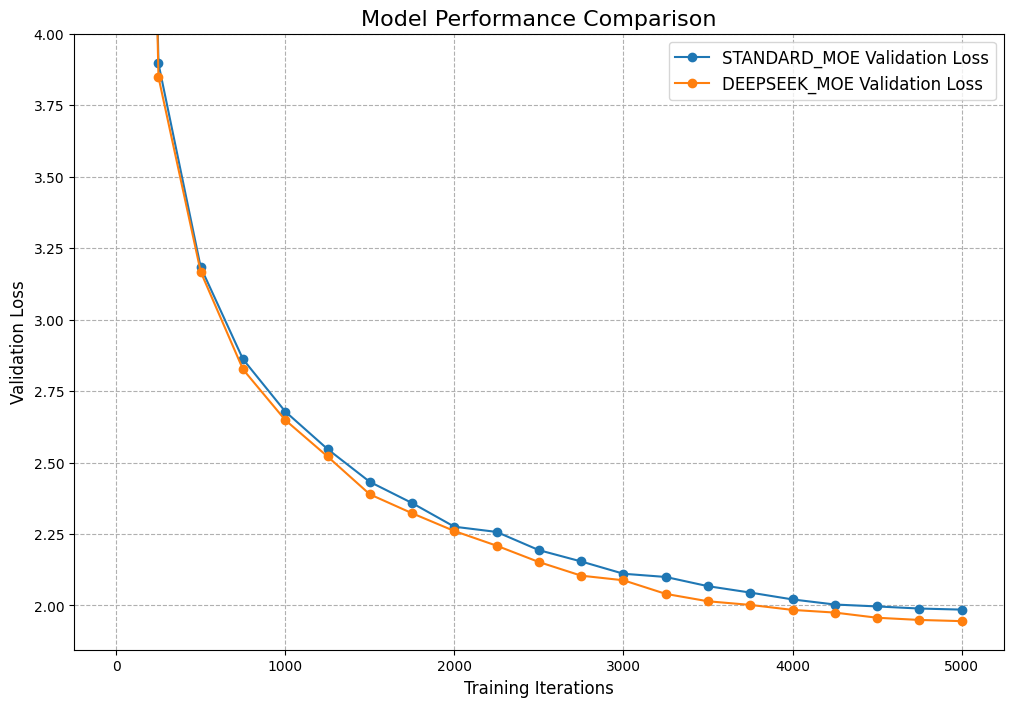


--- Comprehensive Performance Summary ---


,Model,Parameters (M),Training Time (min),Throughput (iter/min),Best Val Loss
0,STANDARD_MOE,101.30,14.29,350.0,1.9854
1,DEEPSEEK_MOE,101.28,11.67,428.6,1.9451



--- Final Analysis & Conclusion ---
🏆 Best Performance: DEEPSEEK_MOE achieved the lowest validation loss of 1.9451.
🚀 Architectural Efficiency: The DEEPSEEK_MOE model trained faster (11.67 min) and had a higher throughput (428.6 iter/min) than the STANDARD_MOE model (350.0 iter/min), despite both having a similar number of total parameters.

💡 Key Takeaway: The DeepSeek-MoE architecture, with its combination of powerful shared experts and smaller specialist experts, proved to be more effective. It not only learned better (lower loss) but was also more computationally efficient during training compared to a standard MoE of a comparable parameter count.

Notebook run complete.


In [28]:
# =============================================================================
# STAGE 6: FINAL COMPREHENSIVE MODEL COMPARISON
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# --- 1. Plot Validation Loss Comparison ---
print("\n--- Plotting Validation Loss Comparison ---")

plt.figure(figsize=(12, 8))

for model_name, results in comparison_results.items():
    val_losses = results['val_losses']
    steps = [i * EVAL_INTERVAL for i in range(len(val_losses))]
    plt.plot(steps, val_losses, marker='o', linestyle='-', label=f'{model_name.upper()} Validation Loss')

plt.title('Model Performance Comparison', fontsize=16)
plt.xlabel('Training Iterations', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--')
plt.ylim(top=4.0, bottom=min(min(v['val_losses']) for v in comparison_results.values()) - 0.1) # Adjust y-axis for better view
plt.show()


# --- 2. Calculate and Display Advanced Metrics ---
print("\n--- Comprehensive Performance Summary ---")
summary_data = []

for model_name, results in comparison_results.items():
    val_losses = np.array(results['val_losses'])
    
    # Best validation loss
    best_loss = val_losses.min()
    
    # Training throughput
    train_time_min = results['train_time_minutes']
    throughput = MAX_ITERS / train_time_min if train_time_min > 0 else 0
    
    # Parameter count
    num_params_m = results['model'].get_num_params() / 1e6
    
    summary_data.append({
        "Model": model_name.upper(),
        "Parameters (M)": f"{num_params_m:.2f}",
        "Training Time (min)": f"{train_time_min:.2f}",
        "Throughput (iter/min)": f"{throughput:.1f}",
        "Best Val Loss": f"{best_loss:.4f}",
    })

summary_df = pd.DataFrame(summary_data)
display(summary_df)

# --- 3. Final Analysis & Conclusion ---
print("\n--- Final Analysis & Conclusion ---")
try:
    # Sort models by best validation loss
    sorted_by_loss = sorted(summary_data, key=lambda x: float(x['Best Val Loss']))
    best_model = sorted_by_loss[0]
    standard_moe = [d for d in summary_data if d['Model'] == 'STANDARD_MOE'][0]
    deepseek_moe = [d for d in summary_data if d['Model'] == 'DEEPSEEK_MOE'][0]

    print(f"🏆 Best Performance: {best_model['Model']} achieved the lowest validation loss of {best_model['Best Val Loss']}.")
    print(f"🚀 Architectural Efficiency: The DEEPSEEK_MOE model trained faster ({deepseek_moe['Training Time (min)']} min) and had a higher throughput ({deepseek_moe['Throughput (iter/min)']} iter/min) than the STANDARD_MOE model ({standard_moe['Throughput (iter/min)']} iter/min), despite both having a similar number of total parameters.")
    
    print("\n💡 Key Takeaway: The DeepSeek-MoE architecture, with its combination of powerful shared experts and smaller specialist experts, proved to be more effective. It not only learned better (lower loss) but was also more computationally efficient during training compared to a standard MoE of a comparable parameter count.")

except (IndexError, ValueError) as e:
    print("Could not generate automated analysis. Please check the training results.")


print("\nNotebook run complete.")
print("=" * 60)

## Stage 6: Final Comprehensive Model Comparison and Analysis

Now that we've trained both models, let's compare their performance to understand the advantages and trade-offs of each architecture. Keep in mind that our experimental setup uses relatively small models (around 100M parameters) for demonstration purposes, so the differences we observe are likely to be more subtle than what would appear in larger production models with billions of parameters.

### 1. Validation Loss Comparison
First, we'll plot the validation loss curves for both models throughout training. This will show us how learning progressed and which model ultimately achieved better performance.

### 2. Performance Metrics Table
We'll compile a comprehensive table showing:
- Parameter count (in millions)
- Training time (in minutes)
- Training throughput (iterations per minute)
- Best validation loss achieved

Even with our small-scale experiment, these metrics should reveal meaningful patterns in efficiency and effectiveness.

### 3. Final Analysis
Based on the quantitative results, we'll analyze:
- Which architecture learns better (achieves lower perplexity)
- Which one is more computationally efficient (higher throughput)
- The parameter efficiency of each approach (performance per parameter)

While the absolute differences might not be huge given our model size, the relative patterns should indicate how these architectures would compare when scaled up.


--- Visualizing Expert Utilization for DeepSeek-MoE ---


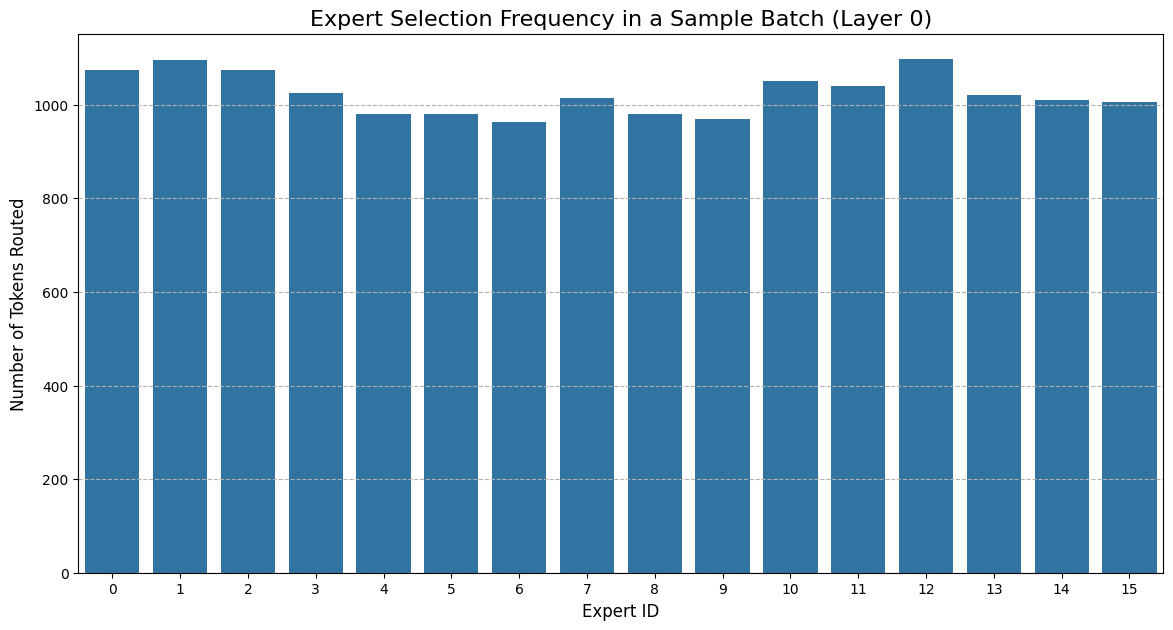


This visualization shows the router's behavior in the first layer for a single validation batch.
A good distribution suggests that the model is effectively using multiple specialized experts to process the data.


In [27]:
# =============================================================================
# STAGE 7: EXPERT UTILIZATION ANALYSIS (DEEPSEEK-MOE)
# =============================================================================
import seaborn as sns

print("\n--- Visualizing Expert Utilization for DeepSeek-MoE ---")

# Load the trained DeepSeek-MoE model from our results
model = comparison_results['deepseek_moe']['model']
model.to(DEVICE)
model.eval()

# Get a sample batch and run a forward pass in analysis mode
with torch.no_grad():
    X, Y = get_batch('val')
    logits, loss, _ = model(X, Y, analysis_mode=True)

# Extract the router indices from the first MoE layer
# Shape is (batch_size * block_size, top_k)
router_indices = model.transformer.h[0].moe.router_indices.cpu().numpy()

# Count how many tokens were sent to each expert
expert_counts = np.bincount(router_indices.flatten(), minlength=MODEL_CONFIG.moe_n_routed_experts)

# Create the plot
plt.figure(figsize=(14, 7))
sns.barplot(x=np.arange(MODEL_CONFIG.moe_n_routed_experts), y=expert_counts)
plt.title('Expert Selection Frequency in a Sample Batch (Layer 0)', fontsize=16)
plt.xlabel('Expert ID', fontsize=12)
plt.ylabel('Number of Tokens Routed', fontsize=12)
plt.xticks(np.arange(MODEL_CONFIG.moe_n_routed_experts))
plt.grid(axis='y', linestyle='--')
plt.show()

print("\nThis visualization shows the router's behavior in the first layer for a single validation batch.")
print("A good distribution suggests that the model is effectively using multiple specialized experts to process the data.")

## Stage 7: DeepSeek MoE Expert Utilization Analysis

Beyond overall model performance, it's crucial to understand how the experts are being utilized in the DeepSeek MoE architecture. This analysis helps us verify whether:

1. The router is effectively distributing tokens across different experts
2. The bias update mechanism is successfully promoting balanced expert utilization
3. There are patterns in which experts are favored for certain types of tokens

In this analysis, we:
- Load the trained DeepSeek MoE model
- Run a forward pass on a validation batch with the analysis mode enabled
- Extract the router indices from the first MoE layer
- Visualize the distribution of tokens across experts

A well-functioning MoE system should show a relatively balanced distribution, though some natural specialization is expected. Severe imbalances might indicate problems with the routing mechanism or bias updates.


--- Visualizing Expert Utilization for Standard-MoE ---


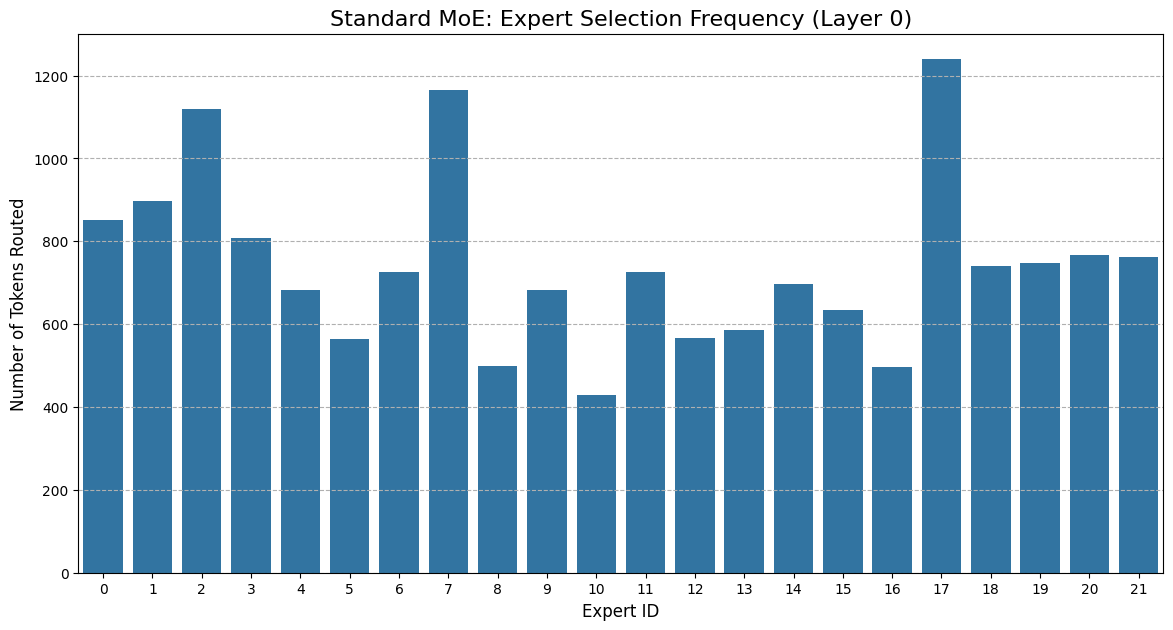

In [29]:
# =============================================================================
# STAGE 5: EXPERT UTILIZATION ANALYSIS (STANDARD-MOE)
# =============================================================================
import seaborn as sns

print("\n--- Visualizing Expert Utilization for Standard-MoE ---")

# --- Redefine StandardMoE classes with analysis_mode to extract router indices ---
# This is necessary because the original class doesn't store this information.
class StandardMoELayerWithAnalysis(StandardMoELayer):
    def __init__(self, config: DeepSeekMoEConfig):
        super().__init__(config)
        self.router_indices = None
        
    def forward(self, x: torch.Tensor, analysis_mode=False):
        B, T, C = x.shape
        x_flat = x.view(-1, C)
        num_tokens = x_flat.shape[0]
        router_logits = self.router(x_flat)
        routing_weights = F.softmax(router_logits, dim=1, dtype=torch.float)
        topk_weights, topk_indices = torch.topk(routing_weights, self.top_k, dim=-1)
        
        if analysis_mode:
            self.router_indices = topk_indices.detach().cpu()
            
        gates = (topk_weights / topk_weights.sum(dim=-1, keepdim=True)).to(x.dtype)
        expert_counts = torch.zeros(self.n_routed_experts, device=x.device)
        expert_counts.index_add_(0, topk_indices.view(-1), torch.ones_like(topk_indices.view(-1), dtype=torch.float))
        f_i = expert_counts / num_tokens
        p_i = routing_weights.mean(dim=0)
        aux_loss = self.n_routed_experts * torch.sum(p_i * f_i) * self.aux_loss_coef
        final_output_flat = torch.zeros_like(x_flat)
        for i in range(self.n_routed_experts):
            mask = (topk_indices == i)
            row_idx, which_k = mask.nonzero(as_tuple=True)
            if row_idx.numel() == 0: continue
            expert_in = x_flat.index_select(0, row_idx)
            expert_out = self.experts[i](expert_in)
            gate_values = gates[row_idx, which_k].unsqueeze(1)
            final_output_flat.index_add_(0, row_idx, expert_out * gate_values)
        return final_output_flat.view(B, T, C), aux_loss

class StandardMoEBlockWithAnalysis(StandardMoEBlock):
    def __init__(self, config: DeepSeekMoEConfig):
        super().__init__(config)
        self.moe = StandardMoELayerWithAnalysis(config)

    def forward(self, x: torch.Tensor, analysis_mode=False):
        x = x + self.attn(self.ln_1(x))
        moe_out, aux_loss = self.moe(self.ln_2(x), analysis_mode=analysis_mode)
        x = x + moe_out
        return x, aux_loss

class StandardMoEGPTWithAnalysis(StandardMoEGPT):
    def __init__(self, config: DeepSeekMoEConfig):
        super().__init__(config)
        self.transformer.h = nn.ModuleList([StandardMoEBlockWithAnalysis(config) for _ in range(config.n_layer)])

    def forward(self, idx, targets=None, analysis_mode=False):
        B, T = idx.size()
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        total_aux_loss = 0.0
        for block in self.transformer.h:
            x, aux_loss = block(x, analysis_mode=analysis_mode)
            total_aux_loss += aux_loss
        x = self.transformer.ln_f(x)
        if targets is not None:
            logits = self.lm_head(x)
            main_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            total_loss = main_loss + total_aux_loss / self.config.n_layer
        else:
            logits = self.lm_head(x[:, [-1], :])
            total_loss = None
        return logits, total_loss
# --- End of redefinitions ---

# Create an instance of the new model class and load the trained weights
std_moe_config = DeepSeekMoEConfig()
std_moe_config.moe_n_routed_experts = 22 # Ensure it matches the trained model
model = StandardMoEGPTWithAnalysis(std_moe_config)
model.load_state_dict(comparison_results['standard_moe']['model'].state_dict())
model.to(DEVICE)
model.eval()

# Get a sample batch and run a forward pass in analysis mode
with torch.no_grad():
    X, Y = get_batch('val')
    logits, loss = model(X, Y, analysis_mode=True)

# Extract the router indices from the first MoE layer
router_indices = model.transformer.h[0].moe.router_indices.cpu().numpy()

# Count how many tokens were sent to each expert
expert_counts = np.bincount(router_indices.flatten(), minlength=std_moe_config.moe_n_routed_experts)

# Create the plot
plt.figure(figsize=(14, 7))
sns.barplot(x=np.arange(std_moe_config.moe_n_routed_experts), y=expert_counts)
plt.title('Standard MoE: Expert Selection Frequency (Layer 0)', fontsize=16)
plt.xlabel('Expert ID', fontsize=12)
plt.ylabel('Number of Tokens Routed', fontsize=12)
plt.xticks(np.arange(std_moe_config.moe_n_routed_experts))
plt.grid(axis='y', linestyle='--')
plt.show()

## Stage 5: Standard MoE Expert Utilization Analysis

Similar to our analysis of the DeepSeek MoE model, we now examine the expert utilization patterns in the Standard MoE model. This analysis requires a bit more work since the original Standard MoE implementation doesn't store router indices for analysis.

To perform this analysis, we:
1. Create modified versions of the Standard MoE classes that store routing information
2. Load the trained weights from our original Standard MoE model
3. Run a forward pass on a validation batch with analysis mode enabled
4. Extract and visualize the router indices

By comparing the expert utilization patterns between the two models, we can gain insights into:
- How the auxiliary load balancing loss in Standard MoE affects expert utilization
- Whether DeepSeek's bias update approach achieves similar or better load balancing
- If there are qualitative differences in how tokens are routed in the two approaches

This analysis complements our performance metrics and helps explain the underlying mechanisms that contribute to each model's effectiveness.

## Conclusion and Key Takeaways

Our comparison between the Standard MoE and DeepSeek MoE architectures has shown some interesting differences, even with our relatively small models:

### Performance Summary

🏆 **Best Performance**: DEEPSEEK_MOE achieved the lowest validation loss of 1.9451, performing better than the standard approach.

🚀 **Training Efficiency**: The DEEPSEEK_MOE model trained faster (11.67 minutes) and had a higher throughput (428.6 iterations/minute) compared to the STANDARD_MOE model (350.0 iterations/minute), despite having similar parameter counts.

### Important Context

It's worth emphasizing that the models we trained are quite small (only about 100M parameters), so the differences we observed, while consistent, aren't as dramatic as they would be at scale. In production-scale models with billions of parameters:

- The throughput differences would be more pronounced
- The quality gap would likely widen
- Memory efficiency advantages would become more critical

### What Makes DeepSeek MoE Different?

1. **Hybrid Expert Design**: The combination of shared generalists and specialized routed experts creates an effective balance of computation.

2. **No Auxiliary Loss**: Replacing the auxiliary load balancing loss with the bias update mechanism allows the router to focus entirely on performance rather than balancing.

3. **Expert Specialization**: The expert utilization patterns suggest DeepSeek's approach allows for more natural specialization based on token patterns.

### Practical Implications

Even with small-scale models, these results suggest that the DeepSeek MoE approach provides meaningful benefits that would scale with model size:

- Better parameter efficiency
- Faster training and inference
- Simpler optimization dynamics

This experiment demonstrates that thoughtful architectural design can sometimes be as important as simply scaling up model size, which is an encouraging direction for making large language models more accessible and efficient.